<a href="https://colab.research.google.com/github/yyyewon/walkvsrun/blob/main/encoder_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 0.6569, Accuracy: 0.5938, F1 Score: 0.5894
Epoch 2/10, Loss: 0.6482, Accuracy: 0.6126, F1 Score: 0.6045
Epoch 3/10, Loss: 0.6483, Accuracy: 0.6206, F1 Score: 0.6196
Epoch 4/10, Loss: 0.6479, Accuracy: 0.6196, F1 Score: 0.6183
Epoch 5/10, Loss: 0.6492, Accuracy: 0.6166, F1 Score: 0.6165
Epoch 6/10, Loss: 0.6480, Accuracy: 0.6177, F1 Score: 0.6171
Epoch 7/10, Loss: 0.6488, Accuracy: 0.6174, F1 Score: 0.6162
Epoch 8/10, Loss: 0.6466, Accuracy: 0.6202, F1 Score: 0.6174
Epoch 9/10, Loss: 0.6458, Accuracy: 0.6222, F1 Score: 0.6200
Epoch 10/10, Loss: 0.6483, Accuracy: 0.6171, F1 Score: 0.6112


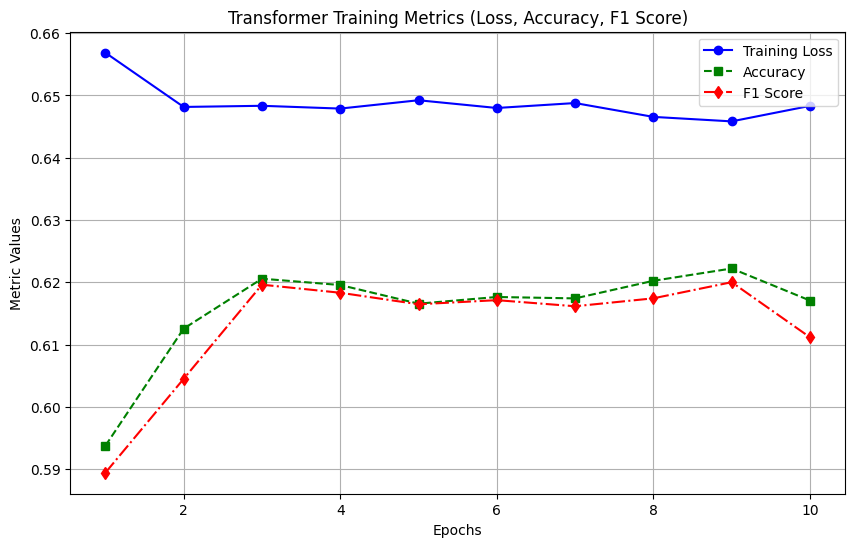

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# === 데이터셋 준비 === #
class TimeSeriesDataset(Dataset):
    def __init__(self, data, features, target, seq_length=10):
        self.features = data[features].values
        self.targets = data[target].values
        self.seq_length = seq_length

    def __len__(self):
        return len(self.features) - self.seq_length + 1

    def __getitem__(self, idx):
        X = self.features[idx:idx + self.seq_length]  # [seq_length, input_dim]
        y = self.targets[idx + self.seq_length - 1]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# === Transformer 기반 분류기 === #
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=4, num_layers=2):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_length, d_model]
        x = x.permute(1, 0, 2)  # Transformer expects [seq_length, batch_size, d_model]
        x = self.transformer(x)  # [seq_length, batch_size, d_model]
        x = x.mean(dim=0)  # Global average pooling over the sequence
        return self.fc(x)

# === 데이터 읽기 === #
file_path = "walkvsrun_sorted.csv"
data = pd.read_csv(file_path)

# === 데이터 전처리 === #
data['full_datetime'] = pd.to_datetime(data['full_datetime'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

features = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z']
target = 'activity'

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data[target])

# Dataset과 DataLoader 생성
seq_length = 10  # 윈도우 크기 설정
input_dim = len(features)
num_classes = data[target].nunique()

train_dataset = TimeSeriesDataset(train_data, features, target, seq_length)
test_dataset = TimeSeriesDataset(test_data, features, target, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === 모델 학습 === #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(input_dim=input_dim, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
epochs = 10
loss_values, accuracy_values, f1_values = [], [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    loss_values.append(train_loss / len(train_loader))

    # 모델 평가
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            _, predicted = torch.max(output, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy_values.append(accuracy)
    f1_values.append(f1)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_values[-1]:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# === 시각화 === #
plt.figure(figsize=(10, 6))

# Loss 그래프
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', label='Training Loss', color='b')

# Accuracy 그래프
plt.plot(range(1, epochs + 1), accuracy_values, marker='s', linestyle='--', label='Accuracy', color='g')

# F1 Score 그래프
plt.plot(range(1, epochs + 1), f1_values, marker='d', linestyle='-.', label='F1 Score', color='r')

# 그래프 설정
plt.xlabel('Epochs')
plt.ylabel('Metric Values')
plt.title('Transformer Training Metrics (Loss, Accuracy, F1 Score)')
plt.legend()
plt.grid()

# 그래프 출력
plt.show()
